In [240]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [241]:
import os
import sys

sys.path.insert(0, 'code')

In [242]:
import json

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

from easydict import EasyDict as edict


from mac import MACNetwork
from utils import IntermediateLayerGetter, load_vocab
from datasets import GQADataset, collate_fn_gqa, ClevrDataset, collate_fn, collate_fn_gqa_objs
from visualize_attentions import plot_word_img_attn_lobs, plot_word_img_attn_objs, idxs_to_question, get_image

In [243]:
model_dir = 'data/gqa_objs_lobs0_sagu/'

In [244]:
with open(os.path.join(model_dir, 'cfg.json'), 'r') as f:
    cfg = json.load(f)

In [245]:
from config import __C, _merge_a_into_b

cfg = edict(cfg)
_merge_a_into_b(cfg, __C)
cfg = __C

print(json.dumps(cfg.model, indent=4))

logcomet is not a valid config key
cfg_file is not a valid config key
exp_name is not a valid config key
manualSeed is not a valid config key
{
    "init_mem": "random",
    "max_step": 4,
    "separate_syntax_semantics": false,
    "use_feats": "objects",
    "num_gt_lobs": 0,
    "common": {
        "module_dim": 512
    },
    "input_unit": {
        "in_channels": 2048,
        "wordvec_dim": 300,
        "rnn_dim": 512,
        "bidirectional": true,
        "separate_syntax_semantics_embeddings": false,
        "stem_act": "ELU",
        "use_feats": "objects"
    },
    "control_unit": {
        "control_feed_prev": true,
        "control_cont_activation": "TANH"
    },
    "read_unit": {
        "gate": false,
        "num_lobs": 0,
        "use_feats": "objects",
        "num_gt_lobs": 0
    },
    "write_unit": {
        "rtom": false,
        "self_attn": true,
        "gate": true,
        "gate_shared": false
    },
    "output_unit": {}
}


In [247]:
dataset = cfg.DATASET.DATASET

if dataset == 'clevr':
    dataset_root = '/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
elif dataset == 'gqa':
    dataset_root = '/Users/sebamenabar/Documents/datasets/GQA/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
cfg.DATASET.DATA_DIR = data_dir
cfg.CUDA = False
cfg.GPU_ID = '-1'

vocab = load_vocab(cfg)
reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']
num_answers = len(reverse_answer_dic)

model = MACNetwork(cfg, vocab, num_answers=num_answers)
state = torch.load(os.path.join(model_dir, 'Model', 'model_checkpoint_000040.pth'), map_location='cpu')
print(model.load_state_dict(state['model'], strict=False))
model.eval()

num_steps = cfg.model.max_step
num_lobs = cfg.model.read_unit.num_lobs
num_gt_lobs = cfg.model.read_unit.num_gt_lobs
read_gate = cfg.model.read_unit.gate
use_feats = cfg.model.use_feats

if read_gate:
    return_layers['mac.read.gate_sigmoid'] = 'read_gate'
if num_lobs > 0:
    return_layers['mac.read.lobs_attn_idty'] = 'lobs_attn'
    
return_layers = {
    'mac.control.cw_attn_idty': 'cw_attn',
    'mac.read.kb_attn_idty': 'kb_attn',
    # 'mac.read.gate_sigmoid': 'read_gate',
    # 'mac.read.lobs_attn_idty': 'lobs_attn',
}
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

split = 'val'
if cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
        use_feats=use_feats,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif cfg.DATASET.DATASET == 'clevr':
    ds = ClevrDataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(dataset_root, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
        ds.questions = json.load(f)['questions']

_IncompatibleKeys(missing_keys=[], unexpected_keys=['input_unit.gt_lobs'])


In [248]:
# q_index = 3

if dataset == 'gqa':
    if use_feats == 'spatial':
        gqa_collate_fn = collate_fn_gqa
    elif use_feats == 'objects':
        gqa_collate_fn = collate_fn_gqa_objs
    b = gqa_collate_fn([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])

with torch.no_grad():
    mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'],)

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]
bboxes = b['image'][0][0, :, -4:]
num_gt_objs = b['image'][1].item()

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

In [249]:
def show_and_tell(q_index):
    # q_index = 3

    if dataset == 'gqa':
        if use_feats == 'spatial':
            gqa_collate_fn = collate_fn_gqa
        elif use_feats == 'objects':
            gqa_collate_fn = collate_fn_gqa_objs
        b = gqa_collate_fn([ds[q_index]])
        image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    elif dataset == 'clevr':
        b = collate_fn([ds[q_index]])
        image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])

    with torch.no_grad():
        mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'],)

    pred = vocab['answer_idx_to_token'][output.argmax().item()]
    gt = vocab['answer_idx_to_token'][b['answer'].item()]
    bboxes = b['image'][0][0, :, -4:]
    num_gt_objs = b['image'][1].item()

    tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

    fig = plot_word_img_attn_objs(
        mid_outputs,
        num_steps,
        tokenized_questions,
        images_dir,
        image_filename,
        pred,
        gt,
        bboxes=bboxes.numpy(),
        num_gt_objs=num_gt_objs,
        num_gt_lobs=num_gt_lobs,
    )
    
    cw_ax = fig.get_axes()[1]
    cw_ax.set_title('Question %d' % q_index)
    plt.tight_layout()
    plt.show()
    
    return fig

In [264]:
q_index = 6000

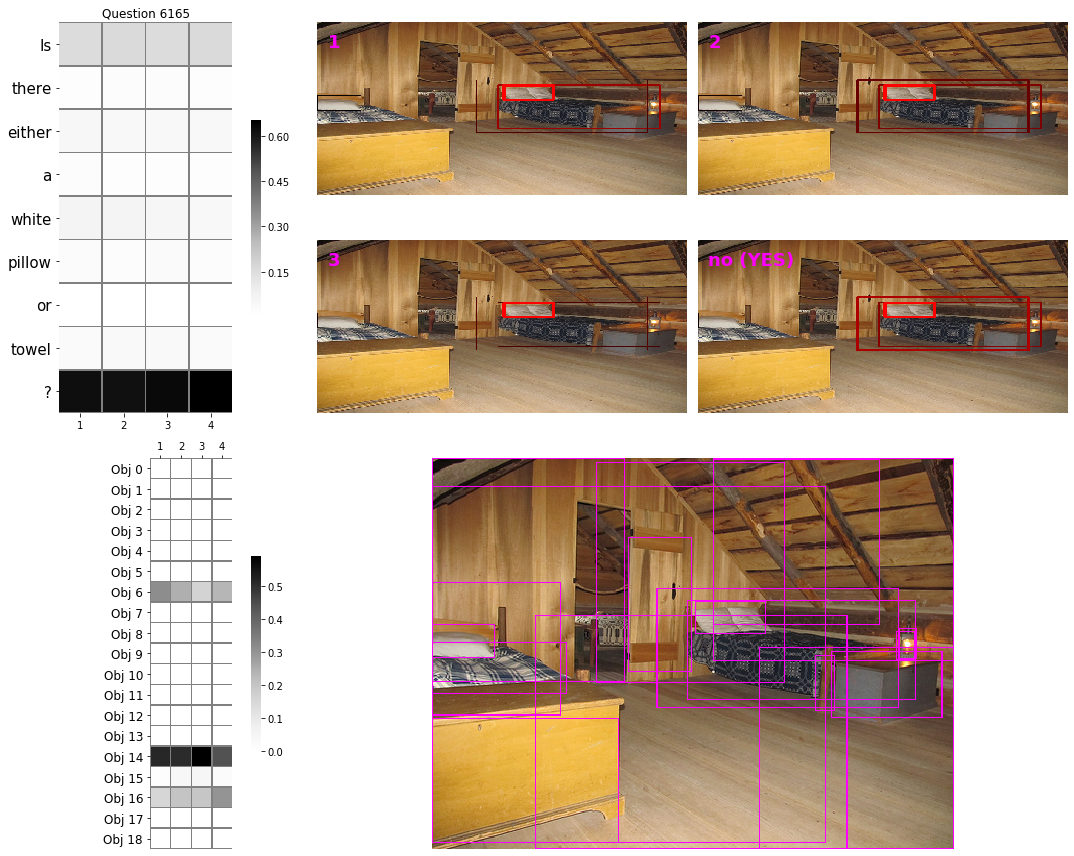

In [294]:
q_index += 11
# q_index = 10
fig = show_and_tell(q_index)

In [270]:
t = torch.randn(10)

In [275]:
t

tensor([ 1.6807,  2.1159, -0.4619,  1.1237, -0.5143,  0.0636,  1.1576,  0.1519,
        -0.8804,  0.8551])

In [278]:
t.topk(2).values[-1].item()

1.6807256937026978

In [90]:
q_index = 4

if dataset == 'gqa':
    b = collate_fn_gqa([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])
    
with torch.no_grad():
    mid_outputs, output = mid_getter(b['image'], b['question'], b['question_length'],)

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

plot_word_img_attn_lobs(
    mid_outputs,
    num_steps,
    tokenized_questions,
    images_dir,
    image_filename,
    pred,
    gt,
    num_lobs,
    read_gate,
)

# print(mid_outputs['read_gate'])

RuntimeError: size mismatch, m1: [14336 x 7], m2: [2052 x 512] at ../aten/src/TH/generic/THTensorMath.cpp:752